In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 20,
                     "savefig.dpi": 500,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}\usepackage[version=4]{mhchem}'
                    }
                   )

In [2]:
from head import AmplitudePhaseDistance

INFO: Using numpy backend


In [3]:
samples = pd.read_csv('./exptdata/grid/grid.csv')
spectra = pd.read_excel('./exptdata/grid/Grid_1.xlsx')
grid_points = spectra['Wavelength'].values.astype('double')
X = spectra.iloc[:,1:].values.astype('double')
grid_points.shape, X.shape

((101,), (101, 49))

In [13]:
# get features
def featurize(x,y):
    peaks, properties = find_peaks(y, prominence=0.05, width=0.4)
    if len(peaks)==0:
        shape = 'Nosignal'
        p1, p2, Ip1, Ip2, fwhm1, fwhm2 = [np.nan]*6
    elif len(peaks)==1:
        shape = 'sphere'
        p1 = x[peaks][0]
        p2 = np.nan
        Ip1 = y[peaks][0]
        Ip2 = np.nan
        fwhm1 = properties["width_heights"][0]
        fwhm2 = np.nan
    elif len(peaks)==2:
        shape = 'cylinder'
        p1 = x[peaks][0]
        p2 = x[peaks][1]
        Ip1 = y[peaks][0]
        Ip2 = y[peaks][1]
        fwhm1 = properties["width_heights"][0]
        fwhm2 = properties["width_heights"][1]
        
    return [shape,p1, p2, Ip1, Ip2, fwhm1, fwhm2]

In [14]:
target = [6.2,3.6]
yt = np.asarray(pd.read_excel('./exptdata/Target_Easy.xlsx'))[:,1]

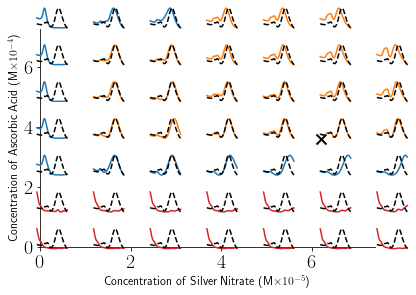

In [15]:
def inset_spectra(loc, wl, I, ax, **kwargs):
        loc_ax = ax.transLimits.transform(loc)
        ins_ax = ax.inset_axes([loc_ax[0],loc_ax[1],0.1,0.1])
        ins_ax.plot(wl, I, **kwargs)
        ins_ax.axis('off')
        
        return

comps = samples.values
AG_x = comps[:,0]*0.00064/350*10**5
AA_x = comps[:,1]*0.00630/350*10**4
comps = np.hstack((AG_x.reshape(-1,1)-0.1, AA_x.reshape(-1,1)-0.1))
AG = [0,7.38] 
AA = [0,7.27]
bounds = [AG, AA]

fig, ax = plt.subplots()
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
for i in range(X.shape[1]-1):
    y = X[:,i]
    feats = featurize(grid_points, y)
    if feats[0]=='Nosignal':
        color = 'tab:red'
    elif feats[0]=='sphere':
        color = 'tab:blue'
    elif feats[0]=='cylinder':
        color = 'tab:orange'
    inset_spectra(comps[i,:], grid_points, y, ax, color=color)
    inset_spectra(comps[i,:], grid_points, yt, ax, color='k', ls='--')
ax.set_xlabel(r'Concentration of Silver Nitrate (M$\times 10^{-5}$)', fontsize = 12)
ax.set_ylabel(r'Concentration of Ascorbic Acid (M$\times 10^{-4}$)', fontsize = 12)
ax.scatter(target[0], target[1], marker='x', 
           color='k', lw=2.0, s=100)
#plt.savefig('../figures/grid.pdf')
plt.show()

In [7]:
ap_dists = []
for i in range(X.shape[1]-1):
    y = X[:,i]
    ap_dists.append(AmplitudePhaseDistance(y, yt, grid_points)) 
ap_dists = np.asarray(ap_dists)

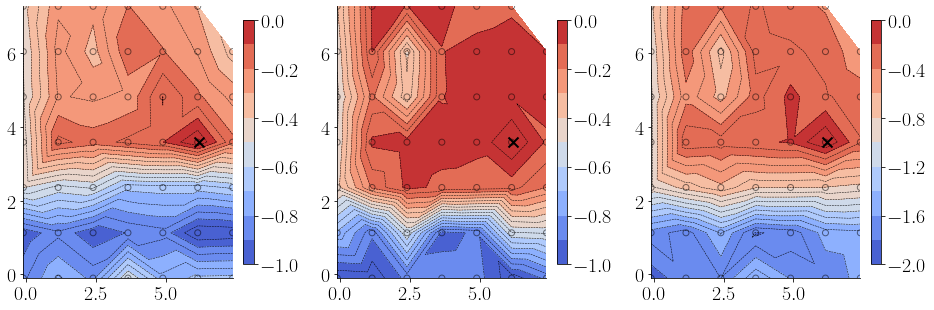

In [16]:
from sklearn.preprocessing import minmax_scale

def plot_tricontour(x,y,z,ax):
    ax.tricontour(
        x,y,z,
        levels=20, 
        linewidths=0.5, 
        colors='k')

    contour = ax.tricontourf(
        x, y, z, 
        levels=10, 
        cmap='coolwarm')

    ax.scatter(
        x,y, 
        marker='o',
        fc='none', 
        edgecolors=(0,0,0),
        alpha=0.5
    )
    ax.scatter(target[0], target[1], marker='x', 
               color='k', lw=2.0, s=100)
    cax = ax.inset_axes([1.05, 0.05, 0.05, 0.9], transform=ax.transAxes)
    fig.colorbar(contour, cax=cax)
    
    return
    
norm_dists = minmax_scale(ap_dists, axis=0)
fig, axs = plt.subplots(1,3,figsize=(3*5,5))
fig.subplots_adjust(wspace=0.5)
x = comps[:,0]
y = comps[:,1]
plot_tricontour(x,y,-norm_dists[:,0],axs[0])
plot_tricontour(x,y,-norm_dists[:,1],axs[1])
plot_tricontour(x,y,-norm_dists.sum(axis=1),axs[2])
plt.show()

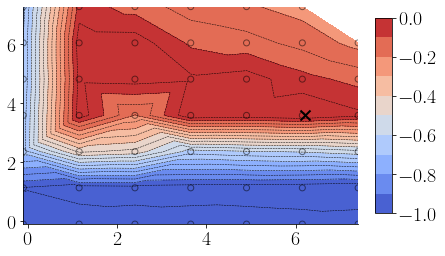

In [17]:
Rn_dists = []
for i in range(X.shape[1]-1):
    y = X[:,i]
    Rn_dists.append(np.sum((y-yt)**2)) 
Rn_dists = np.asarray(Rn_dists)
fig, ax = plt.subplots()
norm_dists = minmax_scale(Rn_dists, axis=0)
plot_tricontour(comps[:,0],comps[:,1],-norm_dists,ax)
plt.show()